In [80]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error metrics
from sklearn.metrics import mean_squared_error

# Time series models
from statsmodels.tsa.arima_model import ARIMA
from keras.layers import LSTM

In [30]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [78]:
pip install tensorflow

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 497.5 MB 8.0 kB/s              00:02 00:02 ████████████▊        | 369.2 MB 89.0 MB/s eta 0:00:02 
     |████████████████████████████████| 5.8 MB 75.5 MB/s            
     |████████████████████████████████| 2.1 MB 23.3 MB/s            
     |████████████████████████████████| 42 kB 197 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 64.7 MB/s            
     |████████████████████████████████| 14.5 MB 63.0 MB/s            
     |████████████████████████████████| 65 kB 556 kB/s             


In [31]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

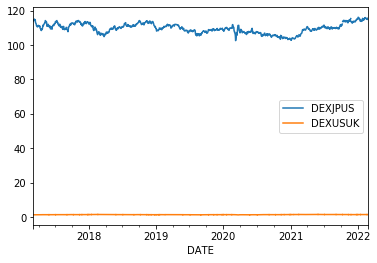

In [32]:
ccy_data.plot();

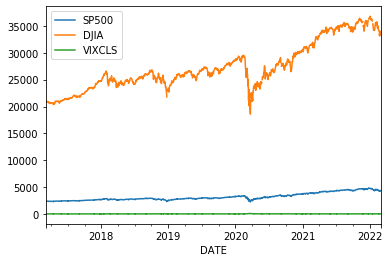

In [33]:
idx_data.plot();

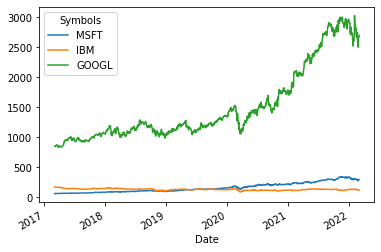

In [34]:
stk_data['Open'].plot();

In [35]:
return_period = 5

In [36]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [37]:
Y.name = 'MSFT_pred'

In [38]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### Exploratory data analysis

##### 3.1 Descriptive analysis

In [39]:
pd.set_option('precision', 3)
dataset.describe()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,-4.900e-04,0.004,3.694e-04,-1.667e-04,0.002,0.002,0.001,0.007,0.021,0.040,0.082,0.006
std,3.716e-02,0.036,8.895e-03,1.223e-02,0.025,0.027,0.175,0.034,0.052,0.065,0.078,0.035
min,-2.312e-01,-0.168,-3.313e-02,-7.267e-02,-0.198,-0.209,-0.495,-0.179,-0.282,-0.229,-0.157,-0.179
25%,-1.530e-02,-0.014,-5.029e-03,-7.053e-03,-0.005,-0.007,-0.079,-0.009,-0.002,0.008,0.045,-0.012
50%,2.727e-03,0.006,8.209e-04,-5.636e-04,0.005,0.005,-0.007,0.009,0.023,0.045,0.087,0.009
75%,1.685e-02,0.025,6.009e-03,6.669e-03,0.014,0.014,0.075,0.026,0.047,0.082,0.130,0.026
max,1.178e-01,0.124,4.089e-02,4.258e-02,0.099,0.116,0.923,0.090,0.156,0.264,0.377,0.090


In [40]:
dataset.head()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-05-30,-5.979e-03,0.033,-0.009,-0.010,6.023e-03,0.004,-0.032,0.028,0.027,0.078,0.097,0.030
2017-06-07,-1.087e-02,0.014,-0.011,0.003,8.809e-03,0.008,-0.002,0.036,0.042,0.069,0.118,-0.030
2017-06-14,1.857e-02,-0.034,-0.003,-0.010,1.963e-03,0.009,0.024,-0.030,0.023,0.020,0.085,0.000
2017-06-21,-1.298e-04,0.011,0.022,-0.011,-9.480e-04,0.002,0.010,0.000,0.006,0.023,0.082,-0.007
2017-06-28,9.899e-03,-0.018,0.005,0.021,2.084e-03,0.002,-0.069,-0.007,-0.036,0.006,0.069,-0.018


In [41]:
dataset.dtypes

IBM          float64
GOOGL        float64
DEXJPUS      float64
DEXUSUK      float64
SP500        float64
DJIA         float64
VIXCLS       float64
MSFT_DT      float64
MSFT_3DT     float64
MSFT_6DT     float64
MSFT_12DT    float64
MSFT_pred    float64
dtype: object

##### 3.2 Data visualization

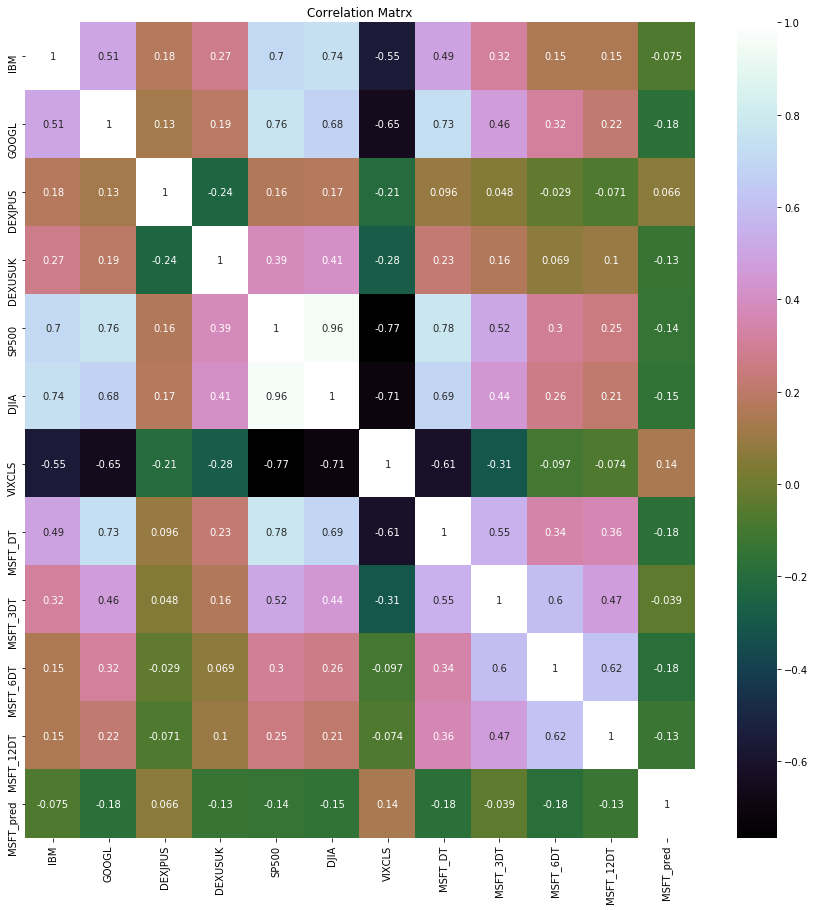

In [42]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrx')
sns.heatmap(correlation, vmax=1, annot=True, cmap='cubehelix')

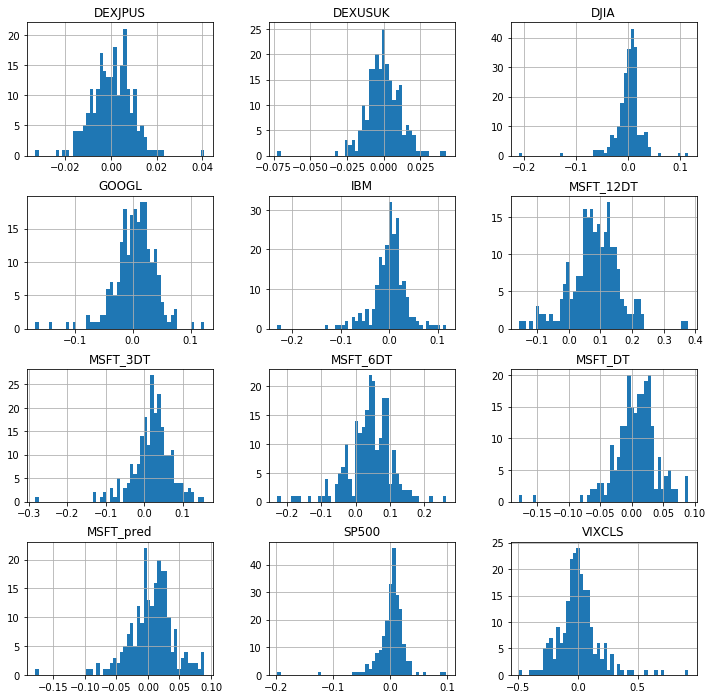

In [43]:
dataset.hist(bins=50, sharex=False, sharey=False,figsize=(12,12));

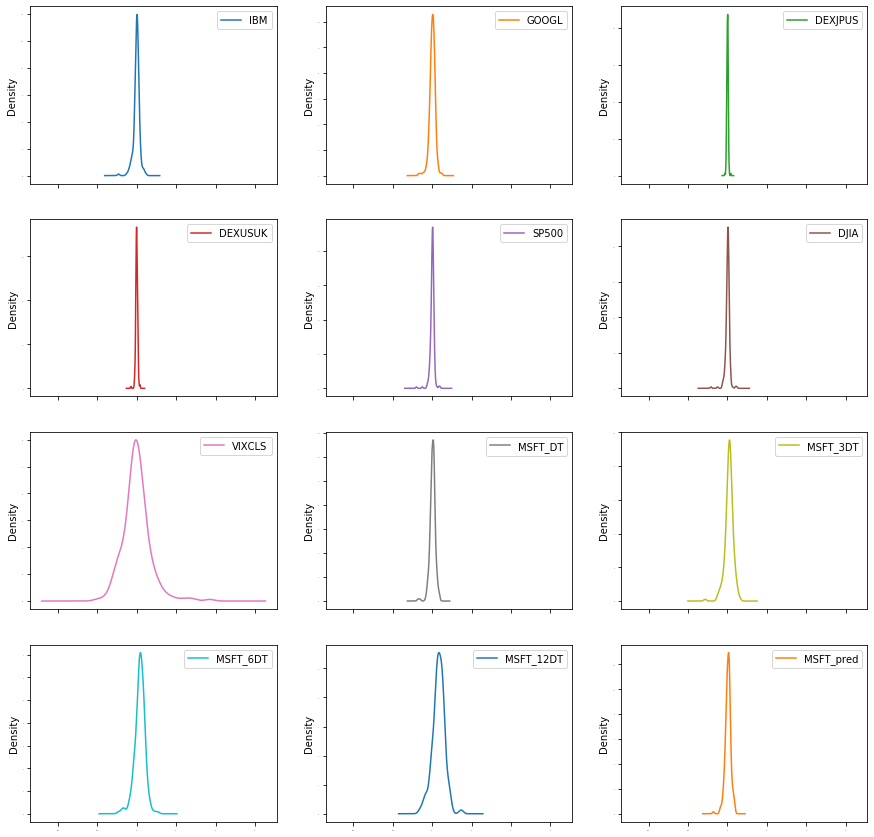

In [44]:
dataset.plot(kind='density', subplots=True, layout=(4,3), legend=True, fontsize=1, sharex=True, figsize=(15,15));

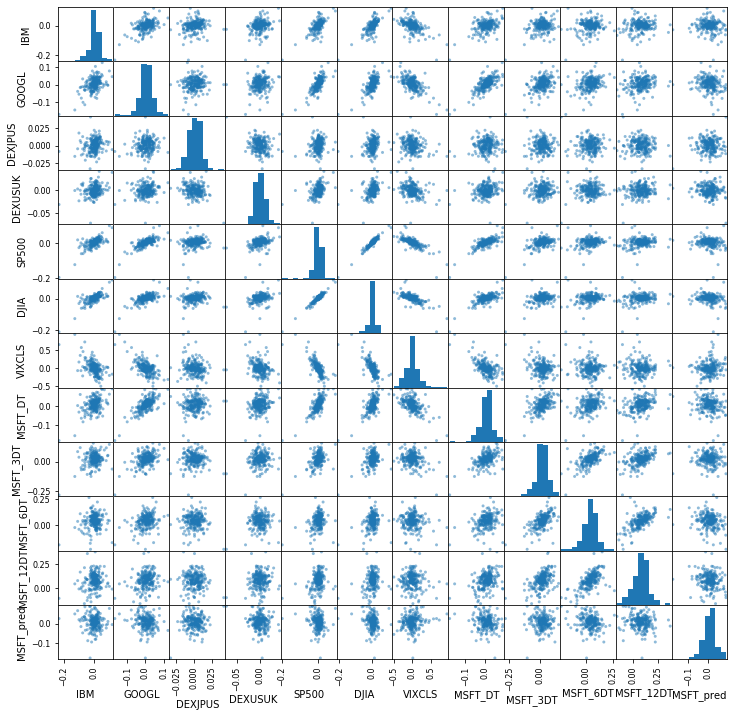

In [45]:
scatter_matrix(dataset, figsize=(12,12));

##### 3.3 Time Series Analysis

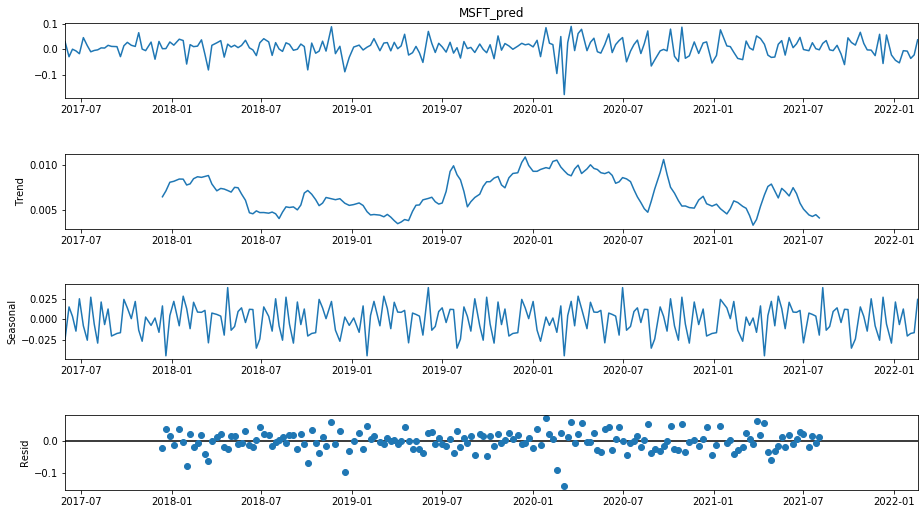

In [46]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 4. Data Preparation
###### 4.2. Feature Selection

In [47]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_6DT,7.570
MSFT_DT,7.317
GOOGL,7.274
DJIA,5.296
SP500,4.729
VIXCLS,4.361
DEXUSUK,4.020
MSFT_12DT,3.628
IBM,1.275


#### 5. Evalute Algorithms and models

##### 5.1 Train test split and evaluation metrics

In [48]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

##### 5.2 Test Options and evaluation metrics

In [49]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

##### 5.3 Compare Models and Algorithms

###### 5.3.1 Machine learning models from scikit-learn

In [50]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('RID', Ridge()))

models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


# Neural Network algorithms
models.append(('LR', MLPRegressor()))

# Ensamble models
#  Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

#  Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [61]:
names = []
kfold_results = []
train_results = []
test_results = []

for name, model in models:
    names.append(name)
    
    # K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_result = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_result)
    
    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    print("%s: %f (%f) %f %f" % (name, cv_result.mean(), cv_result.std(), train_result, test_result))

LR: 0.001282 (0.000982) 0.001079 0.001137
LASSO: 0.001252 (0.001038) 0.001248 0.001040
EN: 0.001252 (0.001038) 0.001248 0.001040
KNN: 0.001447 (0.001052) 0.000922 0.001154
CART: 0.002437 (0.001920) 0.000000 0.001518
SVR: 0.002384 (0.000771) 0.002337 0.001931
RID: 0.001216 (0.000999) 0.001178 0.001022
LR: 0.002955 (0.001785) 0.002507 0.002283
ABR: 0.001506 (0.001164) 0.000769 0.001114
GBR: 0.001647 (0.001063) 0.000091 0.001188
RFR: 0.001390 (0.001074) 0.000204 0.001032
ETR: 0.001462 (0.001056) 0.000000 0.001032


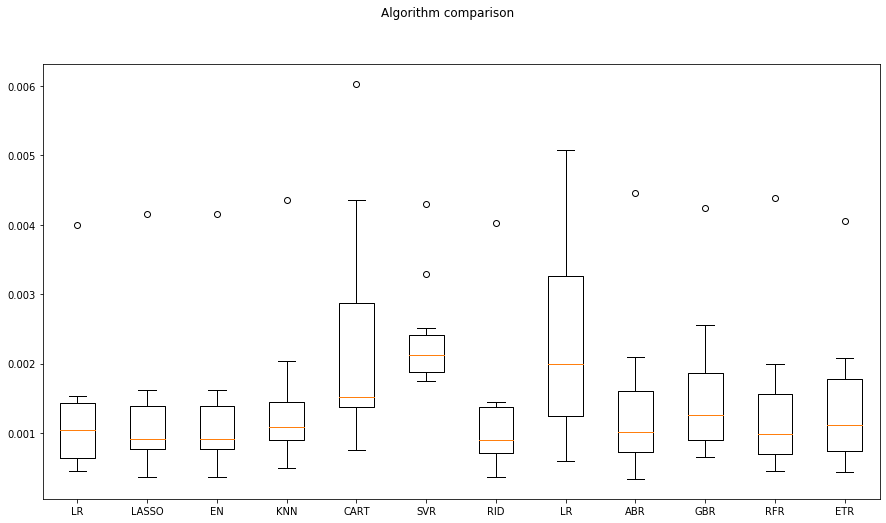

In [56]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

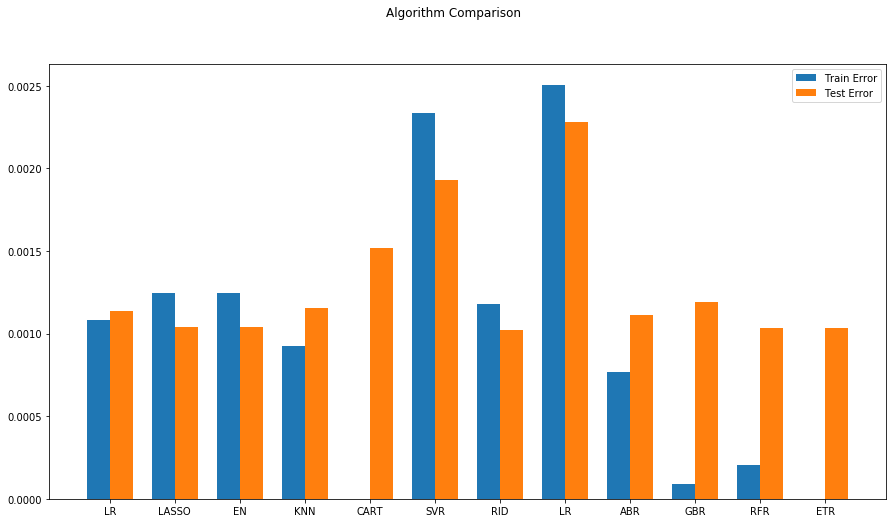

In [66]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

### Time series model - ARIMA model

In [90]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [92]:
error_Train_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len-1, end = to_len-1, exog= X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [94]:
error_Test_ARIMA

0.001098930276351857

### LSTM Model

In [ ]:
# TODO: Next